In [1]:
import os
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
from chessutils import find_coeffs
from boardgen import chessboard

In [3]:
PATH_TO_IMG = 'img'

In [4]:
IMGSIZE = 480
MAXSHEAR = 0.15
MINSCALE = 0.5
NC = 5

In [5]:
figimgs = [f for f in os.listdir(PATH_TO_IMG) if f.split('_')[0]=='Chess']
figuresimgs = dict()
for f in figimgs:
    fn = f.split('_')[1].split('4')[0]
    img = cv2.imread(os.path.join(PATH_TO_IMG, f))
    figuresimgs[fn] = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

figs = ['p', 'b', 'n', 'r', 'q', 'k']
colors = ['d', 'l']

In [6]:
parameters = {
    'numcell':8,
    'cellsize':45,
    'figures':figs,
    'colors':colors,
    'shear':MAXSHEAR,
    'scale':MINSCALE,
}

In [7]:
def randomboardpoints(nc, params):
    boardsize = params['cellsize'] * params['numcell']
    mask = 255*np.ones((boardsize,boardsize), np.uint8)
    nb = params['numcell']*params['numcell']
    npt = np.random.randint(1,nc+1,size=nb)
    for i in range(nb):
        xp = i % params['numcell']
        yp = i // params['numcell']
        sz = npt[i]
        if (xp != 0) and (yp != 0):
            mask[yp*params['cellsize']-sz:yp*params['cellsize']+sz,xp*params['cellsize']-sz:xp*params['cellsize']+sz] = 0
    return mask

In [18]:
def boardmask(imgsize):
    boardimage, _, vecs = chessboard(figuresimgs, np.random.rand(13), imgsize, parameters)
    blank_mask = randomboardpoints(NC, parameters)

    img = Image.fromarray(blank_mask, 'L')
    coeffs = find_coeffs(
         vecs.reshape((4,2)),
         [(0, 0), (blank_mask.shape[1], 0), (blank_mask.shape[1], blank_mask.shape[0]), (0, blank_mask.shape[0])])

    img = img.transform((imgsize, imgsize), Image.PERSPECTIVE, coeffs, Image.NEAREST, fillcolor = 'white')
    
    #msk_out = np.expand_dims(np.asarray(img) / 255, axis=-1)
    
    return 1-np.asarray(img)/255, vecs

In [19]:
def addpoints(img, num):
    xyadd = np.random.rand(num,3)
    for i in range(num):
        xc = int(img.shape[1]*xyadd[i,0])
        yc = int(img.shape[0]*xyadd[i,1])
        nc = int(NC*xyadd[i,2])+1
        img[yc-nc:yc+nc,xc-nc:xc+nc] = 1
    return

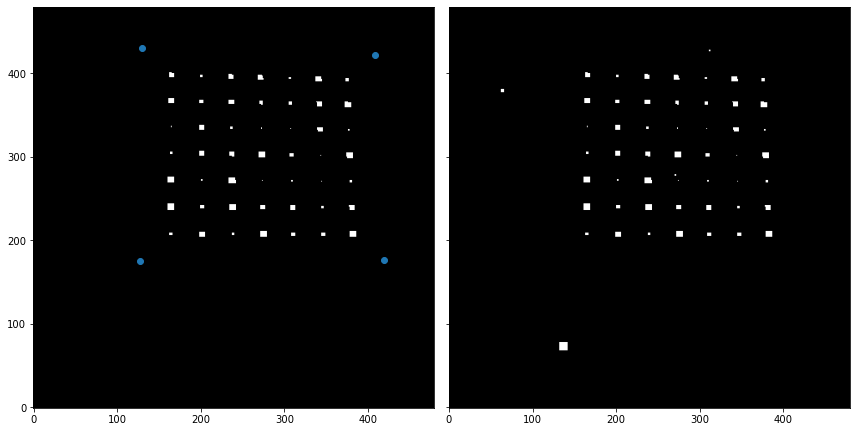

In [20]:
bd, vv = boardmask(IMGSIZE)

fig, axxes = plt.subplots(ncols=2, nrows=1, figsize=(12,6), sharex=True, sharey=True)
axxes[0].imshow(bd, cmap='gray', origin='lower')
axxes[0].scatter(vv.reshape((4,2)).T[0], vv.reshape((4,2)).T[1])
addpoints(bd, NC-1)
axxes[1].imshow(bd, cmap='gray', origin='lower')
fig.tight_layout()
plt.show()

In [21]:
np.unique(bd)

array([0., 1.])

In [23]:
cftbd = np.fft.fft2(bd)

In [29]:
np.real(cftbd).max(), np.real(cftbd).min()

(1423.0, -1112.1646921454349)

In [30]:
np.imag(cftbd).max(), np.imag(cftbd).min()

(820.7983024122618, -820.7983024122618)

In [38]:
cross = np.real(np.fft.ifft2(np.conj(cftbd)*cftbd))

In [36]:
np.real(cross).max(), np.real(cross).min()

(1423.0, -1.2390088954816747e-13)

In [37]:
np.imag(cross).max(), np.imag(cross).min()

(9.440601420736204e-14, -7.683850295046844e-14)

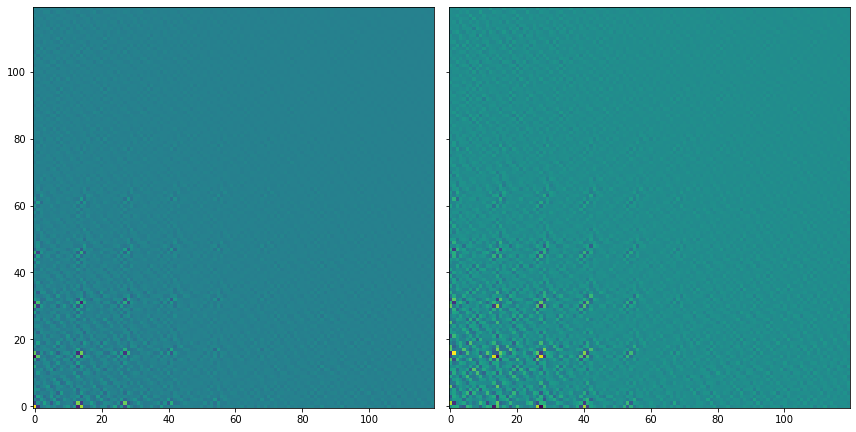

In [32]:
fig, axxes = plt.subplots(ncols=2, nrows=1, figsize=(12,6), sharex=True, sharey=True)
axxes[0].imshow(np.real(cftbd)[:120,:120], origin='lower')
axxes[1].imshow(np.imag(cftbd)[:120,:120], origin='lower')
fig.tight_layout()
plt.show()

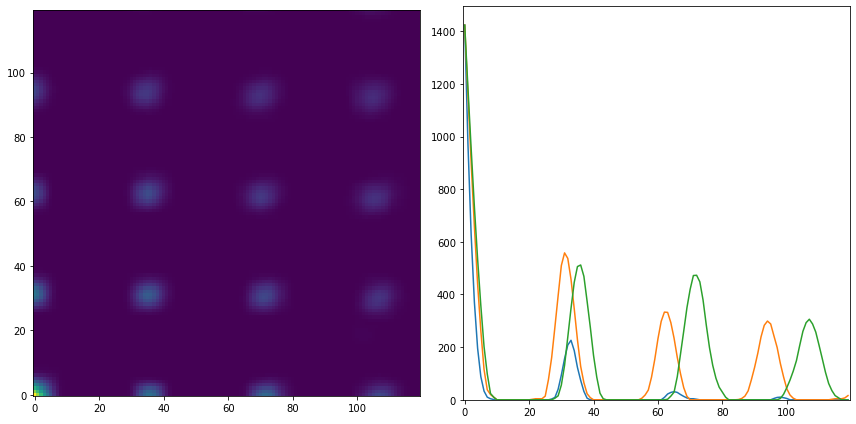

In [45]:
fig, axxes = plt.subplots(ncols=2, nrows=1, figsize=(12,6), sharex=True, sharey=False)
axxes[0].imshow(cross[:120,:120], origin='lower')
axxes[1].plot([cross[i,i] for i in range(120)])
axxes[1].plot([cross[i,0] for i in range(120)])
axxes[1].plot([cross[0,i] for i in range(120)])
axxes[1].set_ylim(0)
fig.tight_layout()
plt.show()